## Part I: Exploratory Data Analysis

### Researching Car Features
I'm not a car expert, I'm more of "hey, as far as it drives, I'm cool with that" type of person. The reason behind choosing this dataset
was simpy to look at the problem analytically, find the appropriate range input variables (and check them against the dataset).

Here what I found out:
- cylinders range, most common: [4, 5, 6, 8], exceptions: [2, 3, 10, 12, 16]
- MPG (miles per gallon), best ones: 35 - 60
- displacement, most common: 2.0L
        (here in cube inches (CI), 1L = 61.024 CI) or L = volume / CI displacement
- horsepower, range: 70 - 200
- acceleration (0 - 60 miles (ca. 97 km)) average: 8 seconds
- origin:
        - America
        - Europe
        - Asia


In [1]:
# import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline

%matplotlib inline
sns.set()

In [2]:
labels = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
cars = pd.read_csv('raw_auto.data', delimiter='\s+', names=labels)

# change the data type of origin to category
cars['origin'] = cars['origin'].astype('category')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mpg           398 non-null    float64 
 1   cylinders     398 non-null    int64   
 2   displacement  398 non-null    float64 
 3   horsepower    398 non-null    object  
 4   weight        398 non-null    float64 
 5   acceleration  398 non-null    float64 
 6   model_year    398 non-null    int64   
 7   origin        398 non-null    category
 8   car_name      398 non-null    object  
dtypes: category(1), float64(4), int64(2), object(2)
memory usage: 25.5+ KB


In [3]:
# check the features according to the findings
cars.describe()

,mpg,cylinders,displacement,weight,acceleration,model_year
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000


As we can see above, horsepower was translated to an <b>object</b> data type. Let's investigate! First, safely convert values
to numeric, then look at the location of the missing values.

Horsepower column data type: float64
Missing values: 6


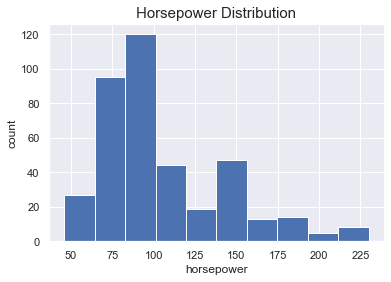

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
32,25.0,4,98.0,NaN,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,NaN,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,NaN,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,NaN,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,NaN,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,NaN,3035.0,20.5,82,1,amc concord dl


In [4]:
# convert to numeric values
cars['horsepower'] = pd.to_numeric(cars['horsepower'], errors='coerce')
print('Horsepower column data type:', cars['horsepower'].dtype)
print('Missing values:', cars['horsepower'].isna().sum())
missing_values = cars[cars['horsepower'].isna()]

# look at distribution
plt.title('Horsepower Distribution', fontsize=15)
cars['horsepower'].plot(kind='hist')
plt.xlabel('horsepower', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.show()

# look at missing values
missing_values

I'm not convinced that bluntly imputing mean values is a good idea. Since there are three types of cars, different cylinders
number, and overall huge differences, I want to look at them separately. We'll start to looking for values that are remotely
on the same scale.


Ford 4 cylinder count: 18
Ford 6 cylinder count: 13
Renault 4 cylinder count: 5
AMC 4 cylinder count: 3


Ford 4 cylinder HORSEPOWER mean: 81.1
Ford 6 cylinder HORSEPOWER mean: 88.3
Renault HORSEPOWER mean: 70.0
AMC HORSEPOWER mean: 85.0


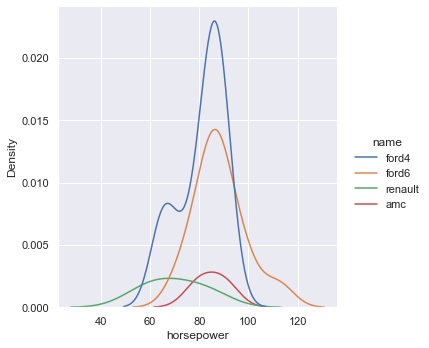

In [5]:
# create separate slices
fords_4cyl = cars[(cars['car_name'].str.startswith('ford')) & (cars['cylinders'] == 4)]
fords_6cyl = cars[(cars['car_name'].str.startswith('ford')) & (cars['cylinders'] == 6)]
renaults = cars[(cars['car_name'].str.startswith('renault')) & (cars['cylinders'] == 4)]
amc = cars[(cars['car_name'].str.startswith('amc')) & (cars['cylinders'] == 4)]

print(f'Ford 4 cylinder count: {len(fords_4cyl)}')
print(f'Ford 6 cylinder count: {len(fords_6cyl)}')
print(f'Renault 4 cylinder count: {len(renaults)}')
print(f'AMC 4 cylinder count: {len(amc)}\n\n')

fords_4cyl_mean = round(fords_4cyl.horsepower.mean(), 1)
fords_6cyl_mean = round(fords_6cyl.horsepower.mean(), 1)
renault_mean = round(renaults.horsepower.mean(), 1)
amc_mean = round(amc.horsepower.mean(), 1)

print(f'Ford 4 cylinder HORSEPOWER mean: {fords_4cyl_mean}')
print(f'Ford 6 cylinder HORSEPOWER mean: {fords_6cyl_mean}')
print(f'Renault HORSEPOWER mean: {renault_mean}')
print(f'AMC HORSEPOWER mean: {amc_mean}')

vals = np.concatenate((fords_4cyl['horsepower'].values, fords_6cyl['horsepower'].values,
                       renaults['horsepower'].values, amc['horsepower'].values), axis=0)
names = np.concatenate((np.repeat(['ford4'], len(fords_4cyl)),
                        np.repeat(['ford6'], len(fords_6cyl)),
                        np.repeat(['renault'], len(renaults)),
                       np.repeat(['amc'], len(amc))), axis=0)
missing_values = pd.DataFrame({'horsepower': vals, 'name': names})

sns.displot(data=missing_values, x='horsepower', hue='name', kind='kde')
plt.show()

In [6]:
# fill missing values
cars.loc[(cars['horsepower'].isna()) & (cars['cylinders'] == 4) & (cars['car_name'].str.startswith('ford')), 'horsepower'] = fords_4cyl_mean
cars.loc[(cars['horsepower'].isna()) & (cars['cylinders'] == 6) & (cars['car_name'].str.startswith('ford')), 'horsepower'] = fords_6cyl_mean
cars.loc[(cars['horsepower'].isna())  & (cars['car_name'].str.startswith('renault')), 'horsepower'] = renault_mean
cars.loc[(cars['horsepower'].isna()) & (cars['car_name'].str.startswith('amc')), 'horsepower'] = amc_mean

# sanity check
print('Missing values count:', len(cars[cars['horsepower'].isna()]))


Missing values count: 0


### Done with missing values!
Time to check the rest



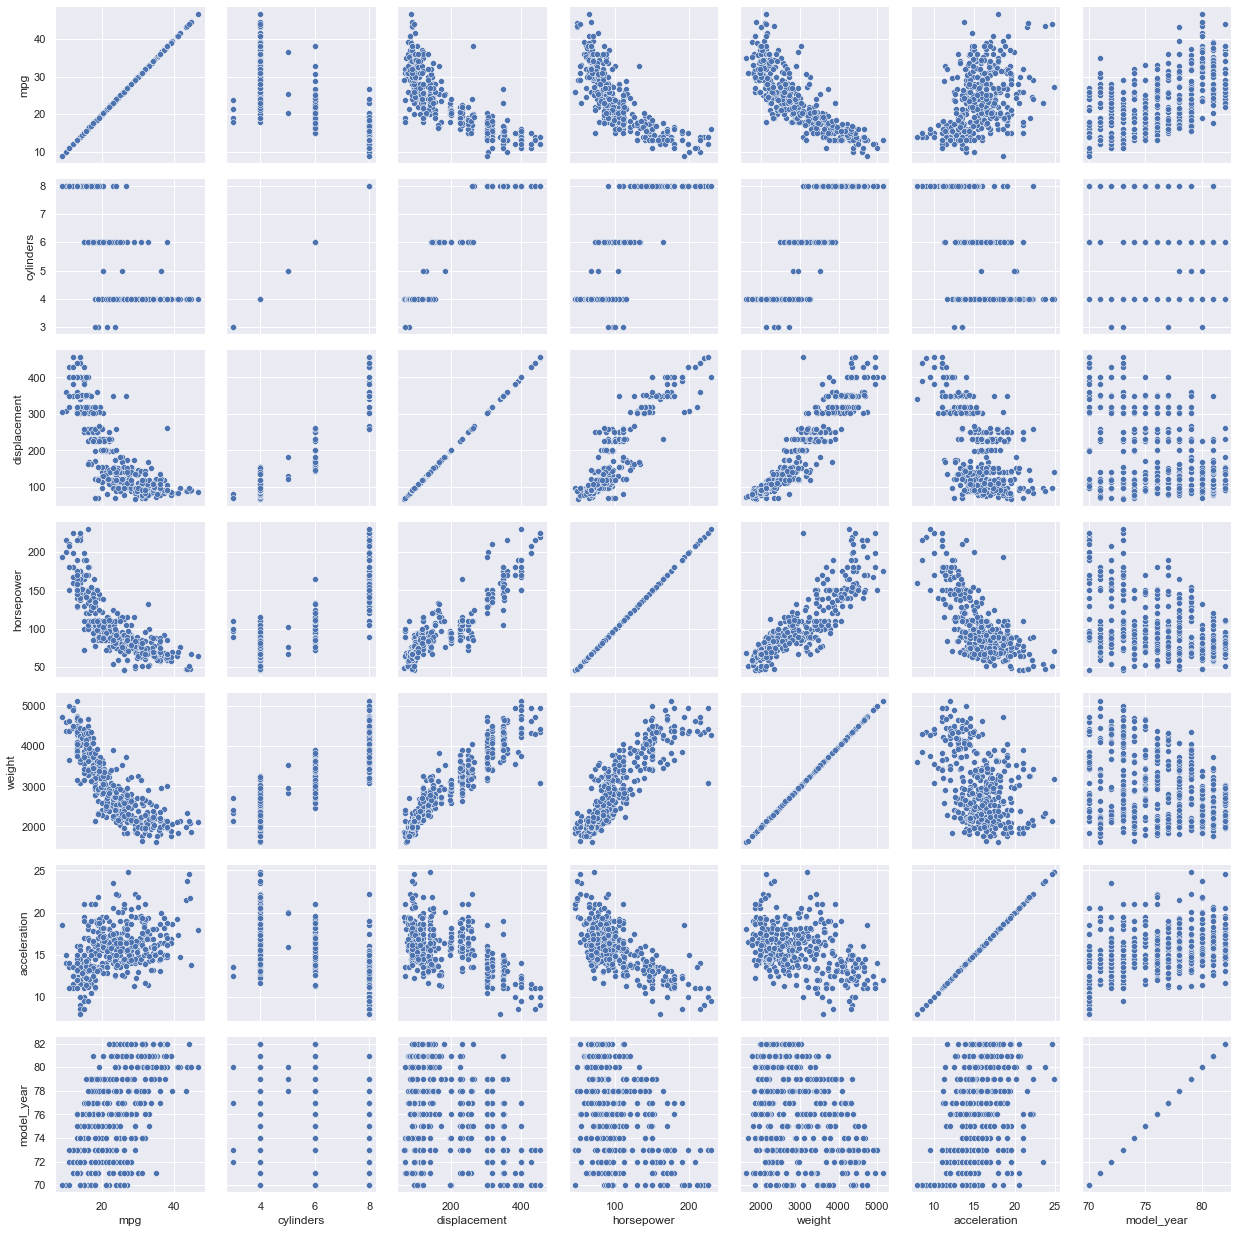

In [7]:
plot = sns.PairGrid(cars)
plot.map(sns.scatterplot)

In [8]:
numeric_only = cars.select_dtypes(exclude='object')
print(numeric_only.shape)

tsne = TSNE(learning_rate=50, verbose=True)
tsne_features = tsne.fit_transform(numeric_only)
print(tsne_features.shape)

(398, 8)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 398 samples in 0.005s...
[t-SNE] Computed neighbors for 398 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 398 / 398
[t-SNE] Mean sigma: 13.590560
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.829346
[t-SNE] KL divergence after 1000 iterations: 0.177227
(398, 2)


<AxesSubplot:xlabel='x', ylabel='y'>

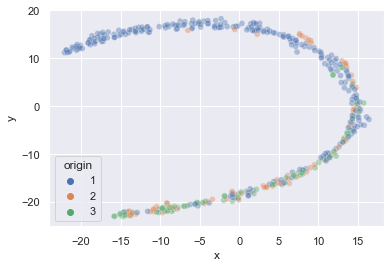

In [9]:
cars['x'] = tsne_features[:, 0]
cars['y'] = tsne_features[:, 1]

sns.set()
sns.scatterplot(x='x', y='y', hue='origin', data=cars, alpha=0.4)

In [10]:
tsne.verbose

True

In [11]:
from sklearn.feature_selection import VarianceThreshold

# X, y = cars.drop(['origin', 'car_name', 'x', 'y'], axis=1).values, cars['origin'].values

# X_st = StandardScaler().fit_transform(X)
selector = VarianceThreshold(threshold=0.005).fit(cars.drop(['car_name', 'x', 'y'], axis=1))
mask = selector.get_support()

print(cars.drop(['car_name', 'x', 'y'], axis=1).iloc[:, mask].shape)

(398, 8)


<AxesSubplot:>

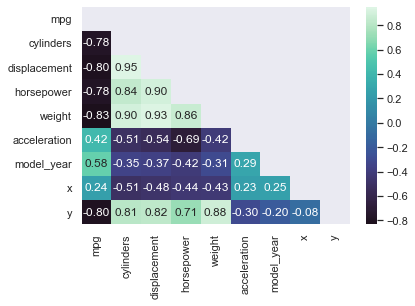

In [12]:
corr = cars.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, center=0, annot=True, fmt='.2f', cmap=sns.cm.mako)

In [13]:
cars[cars.duplicated()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,x,y


In [14]:
from sklearn.metrics import accuracy_score
X, y = cars.drop(['origin', 'car_name', 'x', 'y'], axis=1).values, cars['origin'].values
columns = cars.drop(['origin', 'car_name', 'x', 'y'], axis=1).columns
X = StandardScaler().fit_transform(X)
logreg = LogisticRegression(max_iter=1e5).fit(X, y)
print(logreg.score(X, y))
print(accuracy_score(y, logreg.predict(X)))

0.7788944723618091
0.7788944723618091


In [15]:
for k, v in dict(zip(cars.drop(['car_name', 'x', 'y'], axis=1).columns, logreg.coef_[0])).items():
    print(k, v)

mpg -0.5785159310282109
cylinders -0.4057839111722197
displacement 3.7815964087825447
horsepower -0.7595628754097217
weight -0.7488263043542729
acceleration 0.01639928602510339
model_year 0.3590615579933123


In [16]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=LogisticRegression(max_iter=1e5), verbose=True).fit(X, y)
rfe.support_

# Print the features and their ranking (high = dropped early on)
print(dict(zip(cars.drop(['car_name', 'x', 'y', 'origin'], axis=1).columns, rfe.ranking_)))

# Print the features that are not eliminated
print(cars.drop(['car_name', 'x', 'y', 'origin'], axis=1).iloc[:, rfe.support_])

# Calculates the test set accuracy
acc = accuracy_score(y, rfe.predict(X))
print("{0:.1%} accuracy on test set.".format(acc))

# import statsmodels.api as sm
#
# X = sm.add_constant(X)
# model = sm.MNLogit(y, X).fit()
# model.summary()

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
{'mpg': 2, 'cylinders': 4, 'displacement': 1, 'horsepower': 1, 'weight': 1, 'acceleration': 5, 'model_year': 3}
     displacement  horsepower  weight
0           307.0       130.0  3504.0
1           350.0       165.0  3693.0
2           318.0       150.0  3436.0
3           304.0       150.0  3433.0
4           302.0       140.0  3449.0
..            ...         ...     ...
393         140.0        86.0  2790.0
394          97.0        52.0  2130.0
395         135.0        84.0  2295.0
396         120.0        79.0  2625.0
397         119.0        82.0  2720.0

[398 rows x 3 columns]
75.9% accuracy on test set.


In [17]:
# X = cars.drop(['origin', 'car_name', 'x', 'y'], axis=1)
# X.columns[rfe.support_]
print(rfe.score(X, y))
print(dict(zip(columns, rfe.ranking_)))

0.7587939698492462
{'mpg': 2, 'cylinders': 4, 'displacement': 1, 'horsepower': 1, 'weight': 1, 'acceleration': 5, 'model_year': 3}


In [18]:
X = cars[['cylinders', 'model_year']]
logreg = LogisticRegression(max_iter=1e5).fit(X, y)
print(logreg.score(X, y))

0.6658291457286433


In [19]:
X, y = cars.drop(['origin', 'car_name', 'x', 'y'], axis=1).values, cars['origin'].values
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# random forest classifier
rf = RandomForestClassifier().fit(X_train, y_train)
print(accuracy_score(y_train, rf.predict(X_train)))
print(accuracy_score(y_test, rf.predict(X_test)))
results = pd.DataFrame({'feature': columns, 'importance': rf.feature_importances_})
results = results.sort_values(by='importance', ascending=False)
results

1.0
0.8416666666666667


,feature,importance
2,displacement,0.317448
4,weight,0.167540
3,horsepower,0.155470
0,mpg,0.116840
5,acceleration,0.107983
6,model_year,0.070864
1,cylinders,0.063854


In [ ]:
mask = results['importance'] > 0.01
# X =

In [26]:
rfc = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
rfc.fit(X_train, y_train)

print(dict(zip(columns, rfc.feature_importances_)))
print(accuracy_score(y_train, rfc.predict(X_train)))
print(accuracy_score(y_test, rfc.predict(X_test)))

{'mpg': 0.14778149888096467, 'cylinders': 0.07215289587109641, 'displacement': 0.2628951103082807, 'horsepower': 0.14828690081881013, 'weight': 0.1976635159023829, 'acceleration': 0.10424218909074734, 'model_year': 0.06697788912771792}
1.0
0.8333333333333334


In [30]:
mask = rfc.feature_importances_ > 0.1
print(X[:, mask])
print('Reduced columns:', columns[mask])
print('Original columns:', columns)

[[-0.7064387   1.0906037   0.67679888  0.63086987 -1.29549834]
 [-1.09075062  1.5035143   1.59101061  0.85433297 -1.47703779]
 [-0.7064387   1.19623199  1.19920558  0.55047045 -1.65857724]
 ...
 [ 1.08701694 -0.56103873 -0.52473653 -0.79858454 -1.4407299 ]
 [ 0.57460104 -0.70507731 -0.6553382  -0.40841088  1.10082237]
 [ 0.95891297 -0.71467988 -0.5769772  -0.29608816  1.39128549]]
Reduced columns: Index(['mpg', 'displacement', 'horsepower', 'weight', 'acceleration'], dtype='object')
Original columns: Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year'],
      dtype='object')


In [31]:
X_new = X[:, mask]
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, shuffle=True)
rfc = RandomForestClassifier().fit(X_train, y_train)
print(dict(zip(columns[mask], rfc.feature_importances_)))
print(accuracy_score(y_train, rfc.predict(X_train)))
print(accuracy_score(y_test, rfc.predict(X_test)))

{'mpg': 0.18118970750678437, 'displacement': 0.31498977799088995, 'horsepower': 0.1650544833797939, 'weight': 0.20788342892047876, 'acceleration': 0.1308826022020531}
1.0
0.825


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
# rfe with random forest
rfe = RFE(estimator=RandomForestClassifier(), verbose=1).fit(X_train, y_train)
mask = rfe.support_

# cars.drop(['x', 'y', 'car_name', 'o'])
reduced_X = columns[mask]
print(reduced_X)

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Index(['displacement', 'horsepower', 'weight'], dtype='object')


In [1]:
for x in range(10, 0, -1):
    print(x)

10
9
8
7
6
5
4
3
2
1


In [5]:
x = 'hehe'
try:
    print(int(x)*2)
except:
    pass

In [6]:
import numpy as np
x = np.array([3, 4, True, False, '5.2'])
print(x)


['3' '4' 'True' 'False' '5.2']
